In [191]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.mpl.ticker as mticker
import numpy as np
import pandas as pd

In [192]:
f = nc.Dataset("sst.mon.mean.nc")
all_vars = f.variables.keys()   # get all keys
all_vars_info = f.variables.items()   # output: <class 'dict_items'>
### index at 34 for latitutde, 0 for longitude for the area in Scotland
var = 'sst'
var_info = f.variables[var]
var_data = f[var][:]
temperature = var_data[:, 34, 0]
### change var_data to numpy array
var_data = var_data[:].data

In [193]:
def difference(data, interval=1):
    return [data[i+interval]-data[i] for i in range(len(data)-interval)]

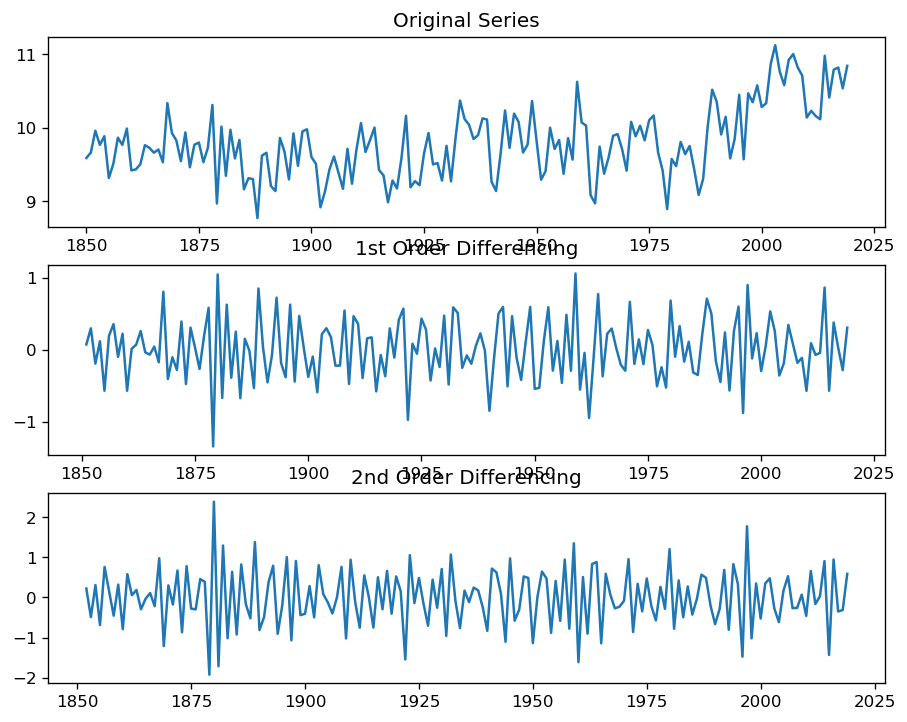

In [194]:
### take the average temperature in a year
year_sst = []
for i in range(0, len(temperature), 12):
    year_sst.append(np.mean(temperature[i:i+12]))
df = pd.DataFrame(np.arange(1850, 2020, 1), columns=['year'])
df['sst'] = year_sst
### Differencing the year_sst
df['diff_1'] = df.sst.diff().dropna()
df['diff_2'] = df.sst.diff().diff().dropna()
fig, ax = plt.subplots(3, 1)
ax[0].plot(df['year'], df['sst']);ax[0].set_title('Original Series')
ax[1].plot(df['year'], df['diff_1']);ax[1].set_title('1st Order Differencing')
ax[2].plot(df['year'], df['diff_2']);ax[2].set_title('2nd Order Differencing')
plt.show()

In [195]:
### then do the stationarity test
print(adfuller(df['sst']))  # 原始数据
print(adfuller(df['diff_1'].dropna()))  # 一阶差分
print(adfuller(df['diff_2'].dropna()))  # 二阶差分
### the 1st difference data is stationary, hence d = 1 for ARIMA model (1st's result is not good, try d=2)

(-2.1140968591727862, 0.23888409439462294, 4, 165, {'1%': -3.470616369591229, '5%': -2.8792214018977655, '10%': -2.57619681359045}, 146.3834169538908)
(-5.825718199188656, 4.083920825480395e-07, 13, 155, {'1%': -3.4732590518613002, '5%': -2.880374082105334, '10%': -2.5768120811654525}, 146.28256452689232)
(-7.084205243680384, 4.583133662263898e-10, 14, 153, {'1%': -3.473829775724492, '5%': -2.880622899711496, '10%': -2.5769448985432954}, 168.5355021273969)


In [196]:
# then do the white noise test
print(acorr_ljungbox(df['diff_1'][1:], lags=10))
# here the p-value of 1st difference data is e-7, which is less than 0.05, hence the data is not white noise
print(acorr_ljungbox(df['diff_2'][2:], lags=10))
# the p-value of 2nd Order difference data is smaller

      lb_stat     lb_pvalue
1   27.779432  1.359639e-07
2   27.842434  8.996886e-07
3   30.561722  1.051250e-06
4   30.589637  3.711883e-06
5   30.646923  1.099732e-05
6   30.655716  2.948833e-05
7   32.345293  3.504532e-05
8   35.101860  2.561994e-05
9   35.141125  5.626281e-05
10  35.432736  1.053129e-04
      lb_stat     lb_pvalue
1   72.027342  2.122362e-17
2   78.980454  7.073140e-18
3   80.477392  2.424558e-17
4   80.666501  1.258321e-16
5   80.681811  6.042209e-16
6   80.875596  2.355612e-15
7   83.087872  3.226034e-15
8   86.072602  2.907600e-15
9   86.410230  8.526288e-15
10  87.197938  1.921518e-14


c:\Users\Sycamore\anaconda3\envs\MCM\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


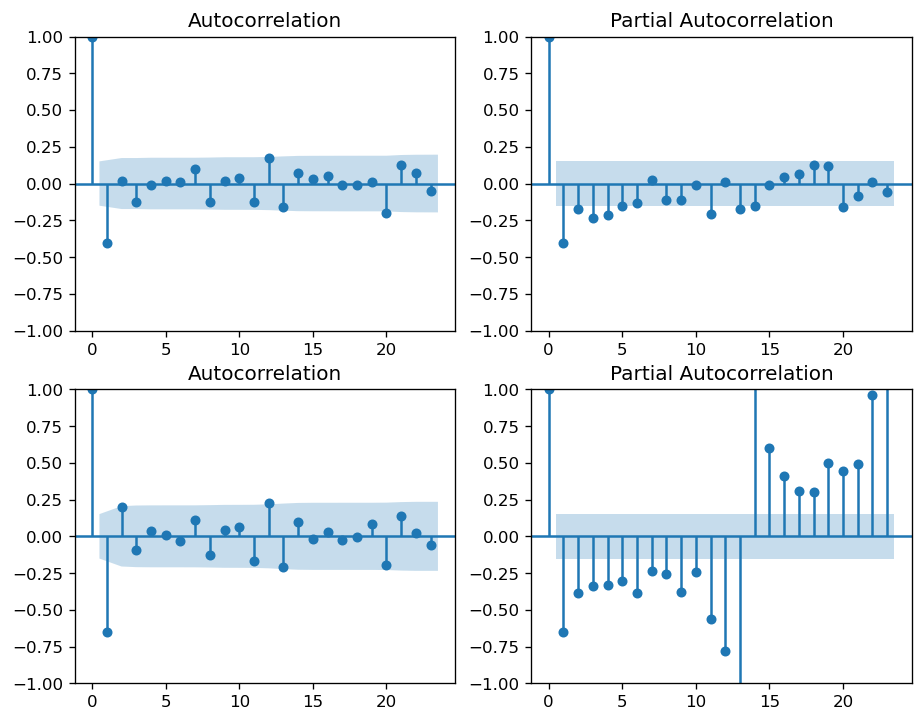

In [197]:
### plot acf and pacf to find p and q
fig, ax = plt.subplots(2, 2)

# 1st Differencing
ax[0, 0].set_title('1st Order Differencing')
plot_acf(df['diff_1'][1:], ax=ax[0, 0])
plot_pacf(df['diff_1'][1:], ax=ax[0, 1])

# 2st Differencing
ax[1, 0].set_title('2nd Order Differencing')
plot_acf(df['diff_2'][2:], ax=ax[1, 0])
plot_pacf(df['diff_2'][2:], ax=ax[1, 1])
plt.show()

In [198]:
### then use AIC and BIC to find the best p and q in diff_1
train_results = sm.tsa.arma_order_select_ic(df['diff_1'][1:], ic=['aic', 'bic'], trend='n', max_ar=8, max_ma=8)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

# then use AIC and BIC to find the best p and q in diff_2
train_results = sm.tsa.arma_order_select_ic(
    df['diff_2'][2:], ic=['aic', 'bic'], trend='n', max_ar=8, max_ma=8)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)


c:\Users\Sycamore\anaconda3\envs\MCM\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Sycamore\anaconda3\envs\MCM\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Sycamore\anaconda3\envs\MCM\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Sycamore\anaconda3\envs\MCM\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Sycamore

AIC (8, 8)
BIC (1, 1)


c:\Users\Sycamore\anaconda3\envs\MCM\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Sycamore\anaconda3\envs\MCM\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Sycamore\anaconda3\envs\MCM\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Sycamore\anaconda3\envs\MCM\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Sycamore\anaconda3\envs\MCM\lib\site-packag

AIC (1, 2)
BIC (1, 2)


c:\Users\Sycamore\anaconda3\envs\MCM\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\Sycamore\anaconda3\envs\MCM\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Sycamore\anaconda3\envs\MCM\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


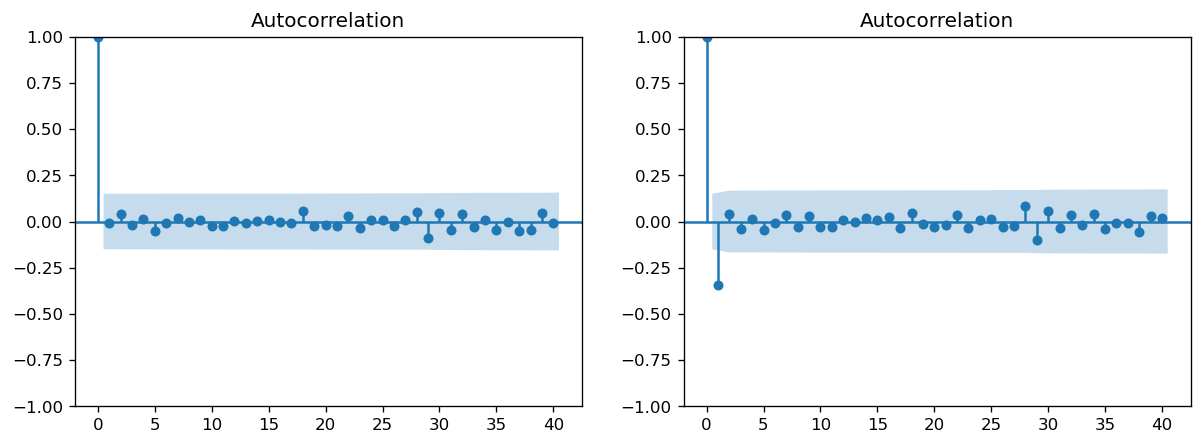

In [199]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# 1st Differencing
# p = 8, d = 1, q = 8, ARIMA(p, d, q)
model_1 = sm.tsa.ARIMA(df['sst'], order=(8, 1, 8))
results_1 = model_1.fit()
resid_1 = results_1.resid  # 残差
plot_acf(resid_1.squeeze(), lags=40, ax=ax[0])
# the ploting result shows that the residual error is white noise

# # p = 1, d = 2, q = 2, ARIMA(p, d, q)
model_2 = sm.tsa.ARIMA(df['sst'], order=(1, 2, 2))
results_2 = model_2.fit()
resid_2 = results_2.resid  # 残差
plot_acf(resid_2.squeeze(), lags=40, ax=ax[1])
plt.show()
# the ploting result shows that the residual error is white noise


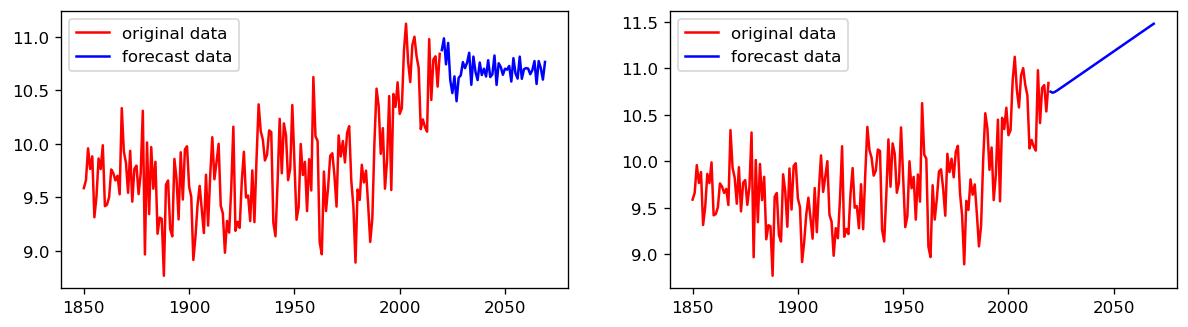

In [200]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
### now plot the original data and the 1st diff forecast data together
future_sst_1 = results_1.forecast(steps=50)
ax[0].plot(np.arange(1850, 2020, 1), df['sst'], "r", label="original data")
ax[0].plot(np.arange(2020, 2070, 1), future_sst_1, "b", label="forecast data")
ax[0].legend()

### now plot the original data and the 1st diff forecast data together
future_sst_2 = results_2.forecast(steps=50)
ax[1].plot(np.arange(1850, 2020, 1), df['sst'], "r", label="original data")
ax[1].plot(np.arange(2020, 2070, 1), future_sst_2, "b", label="forecast data")
ax[1].legend()
plt.show()

c:\Users\Sycamore\anaconda3\envs\MCM\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
c:\Users\Sycamore\anaconda3\envs\MCM\lib\site-packages\cartopy\crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
c:\Users\Sycamore\anaconda3\envs\MCM\lib\site-packages\cartopy\crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
c:\Users\Sycamore\anaconda3\envs\MC

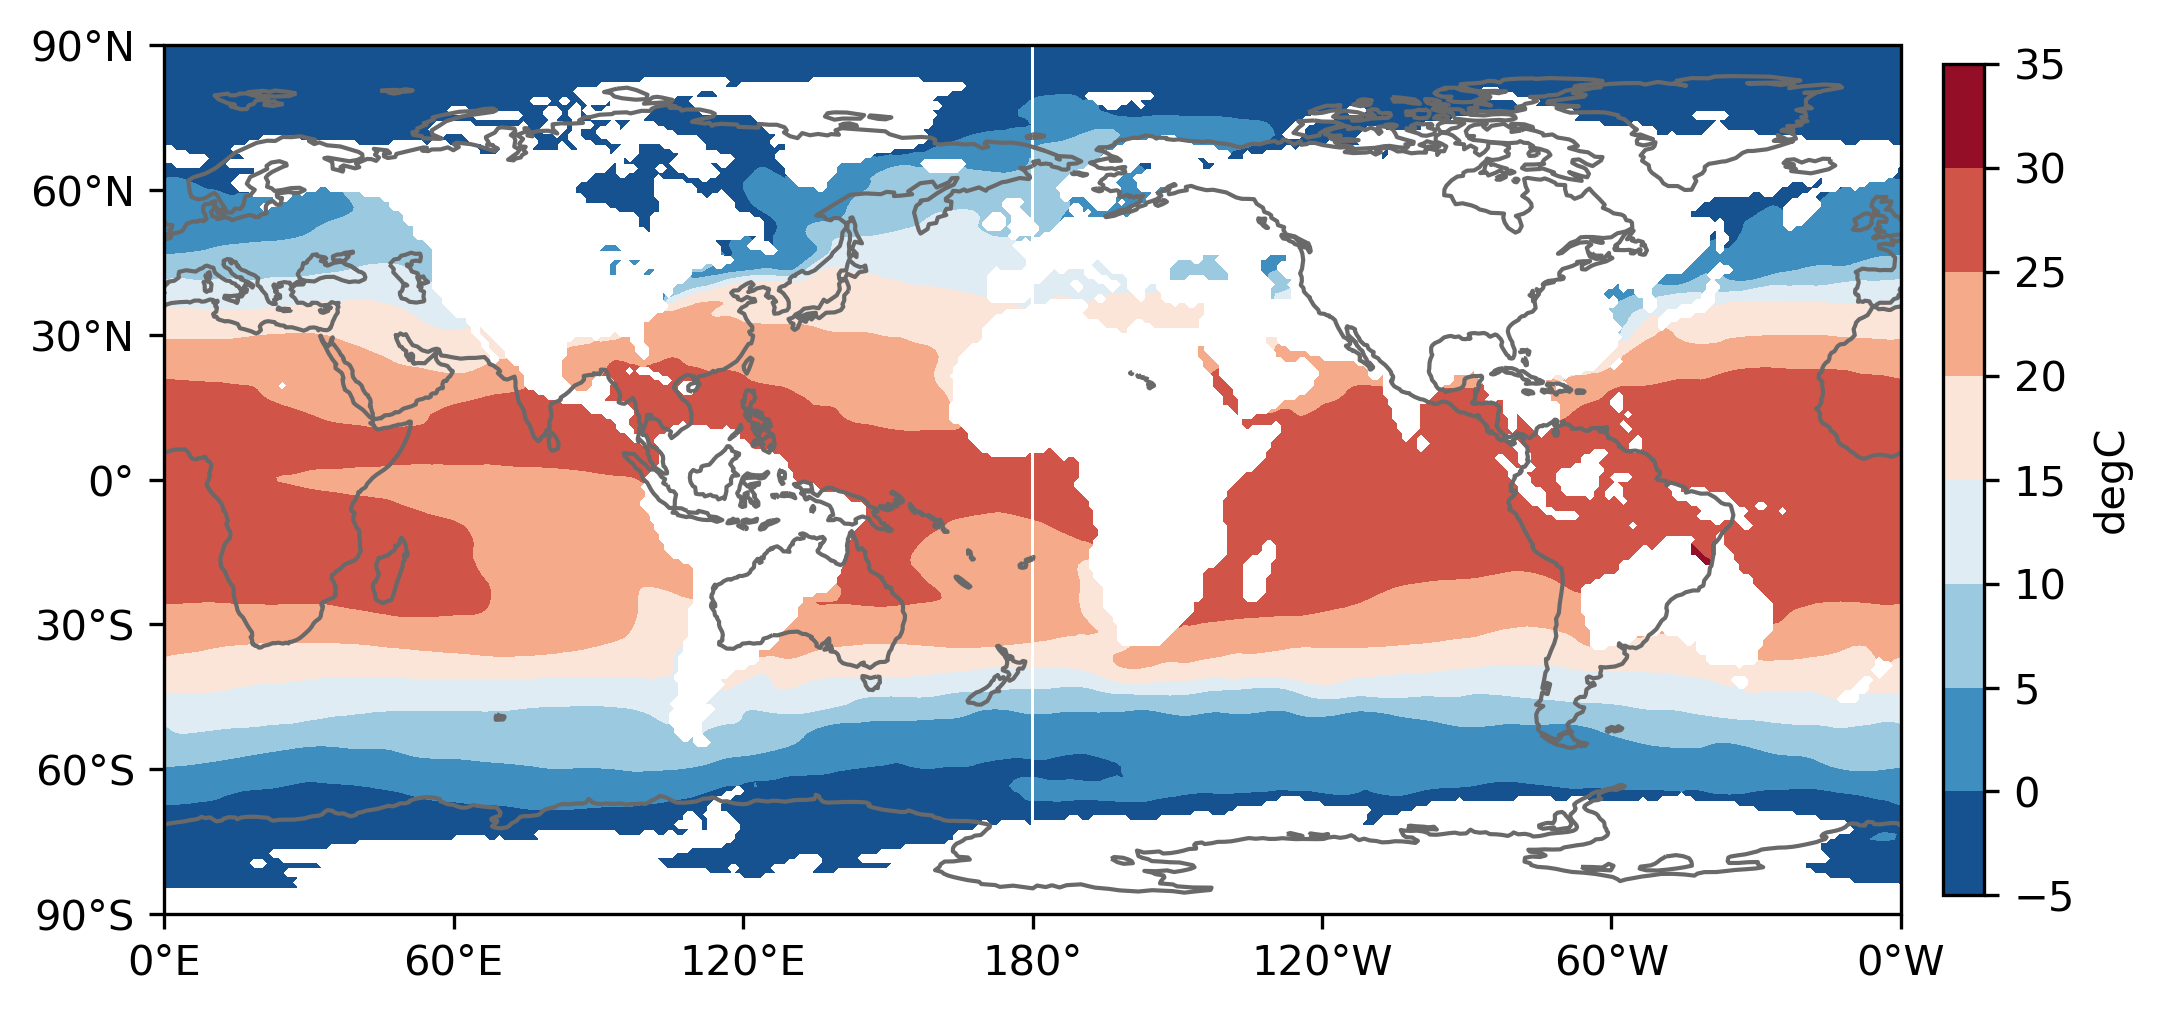

In [201]:
# 全球的sst分布图
def read_ssttemper(filename):
    temperFn = filename
    tfid = nc.Dataset(temperFn)
    lon = tfid.variables['lon'][:]
    lat = tfid.variables['lat'][:]
    sst = tfid.variables['sst'][0, :, :]  # air temperature unit: degC
    return lon, lat, sst


def plot_ssttemper(sstdatafile):
    lon, lat, sst = read_ssttemper(sstdatafile)
    proj = ccrs.PlateCarree(central_longitude=180)  # create a map projection
    fig = plt.figure(figsize=(9, 6), dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    cs = ax.contourf(lon, lat, sst, transform=proj, cmap='RdBu_r')  # draw contour lines
    ax.coastlines(color='dimgray')  # draw coastline, Dimgray／昏灰／#696969
    ax.set_global()  # 指定坐标系统的限制由整个地球形成
    cbar = fig.colorbar(cs, orientation='vertical',
                        pad=0.02, aspect=20, shrink=0.6)
    cbar.set_label('degC')

    # Mark lat and lon on the coordinate axis
    xticks = [-180, -120, -60, 0, 60, 120, 180]
    ax.set_xticks(xticks, crs=proj)
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=proj)
    lon_formatter = mticker.LongitudeFormatter(zero_direction_label=True)
    lat_formatter = mticker.LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    # plt.savefig(r'test.jpg', dpi=300)
    # plt.show()

plot_ssttemper("C:\\Users\\Sycamore\\Workplace\\Jupyter\\tmp\\sst.mon.mean.nc")